# Proyecto 2 CNN - GRU

In [1]:
import pandas as pd
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import ndimage
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import cv2
from PIL import Image
from zipfile import ZipFile
from torchvision import transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score

In [2]:
sample = 600

In [3]:
data_VGG = pd.read_csv('train_filtrado_images.csv')
data_VGG = data_VGG.sample(n=sample, random_state=42)

In [4]:
data_vertebrae = pd.read_csv('meta_train_with_vertebrae.csv')

In [5]:
train_data, test_data = train_test_split(data_VGG, test_size=0.2, random_state=42)

In [6]:
# Parámetros del modelo
vgg_output_size = 1280  # Tamaño de la salida de la VGG16
gru_hidden_size = 128  # Tamaño del estado oculto de la GRU
gru_num_layers = 2  # Número de capas en la GRU
num_classes = 7  # Reemplaza con el número de clases en tu problema

In [7]:
class WeightedMultiLabelLogLoss(nn.Module):
    def __init__(self, weight=None):
        super(WeightedMultiLabelLogLoss, self).__init__()
        self.weight = weight

    def forward(self, input, target):
        """
        Computes the weighted multi-label logarithmic loss.

        Args:
            input (torch.Tensor): Predicted probabilities (output of the model).
                                Shape: (batch_size, num_classes)
            target (torch.Tensor): Target labels (ground truth).
                                Shape: (batch_size, num_classes)

        Returns:
            loss (torch.Tensor): Weighted multi-label logarithmic loss.
        """
        epsilon = 1e-15  # Small constant to avoid log(0)
        # Log loss
        log_loss = -target * torch.log(input + epsilon) - (1 - target) * torch.log(1 - input + epsilon)
        
        # Apply weights if provided
        if self.weight is not None:
            log_loss = log_loss * self.weight

        # Compute mean loss over samples and classes
        loss = log_loss.mean()
        return loss

In [11]:
import torch.nn.functional as F

class CombinedModel(nn.Module):
    def __init__(self, efficientnet_output_size, gru_hidden_size, gru_num_layers, num_classes):
        super(CombinedModel, self).__init__()
        
        # Cargar EfficientNet preentrenado
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        # Eliminar la capa Fully Connected
        self.features = nn.Sequential(*list(self.efficientnet.children())[:-1])
        
        # Pooling Global Promedio
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # GRU Layer
        self.gru = nn.GRU(input_size=efficientnet_output_size, hidden_size=gru_hidden_size, batch_first=True)
        
        # Fully Connected Layer
        self.fc = nn.Linear(gru_hidden_size, 1)
        self.dropout = nn.Dropout(0.5)
        
        # Softmax
        # self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        x = x.view(batch_size * timesteps, C, H, W)
        
        # Pasar imágenes por EfficientNet
        x = self.features(x)
        
        # Pooling Global Promedio
        x = self.global_avg_pool(x).squeeze(-1).squeeze(-1)
        
        x = x.view(batch_size, timesteps, -1)
        # print(x.shape)
        # Pasar la secuencia de feature maps por la GRU
        out, _ = self.gru(x)
        # Usar solo la última salida de la secuencia
        out = out[:, -1, :]
        # Pasar por la capa Fully Connected
        out = self.dropout(self.fc(out))
        # Softmax
        out = self.sigmoid(out)
        
        return out


In [12]:
if torch.cuda.is_available():
    print('GPU está disponible')
else:
    print('No se encontró GPU, usando CPU')

GPU está disponible


In [13]:
# Crea una instancia del modelo combinado
combined_model = CombinedModel(vgg_output_size, gru_hidden_size, gru_num_layers, num_classes)

c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
combined_model.to('cuda')

CombinedModel(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (

In [16]:
# Define la función para preprocesar las imágenes para VGG16 y CombinedModel
def preprocess_image_for_combined_model(image):
    # Transformaciones para preprocesar las imágenes para VGG16
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Cambiar el tamaño a 224x224 (tamaño de entrada de la VGG16)
        transforms.ToTensor(),  # Convertir a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización requerida por VGG16
    ])

    preprocessed_image = transform(image)  # Aplica las transformaciones
    return preprocessed_image

In [19]:
def apply_PCA(images):
    images_flat = images.reshape(images.shape[0], -1).numpy()  # Aplanar y convertir a numpy
    pca = PCA(n_components=70)  # Instanciar PCA
    transformed = pca.fit_transform(images_flat)  # Aplicar PCA
    return transformed

In [20]:
class ImageDataGenerator:
    def __init__(self, df, ct_folder, max_samples, cervical, vertebrae_info, batch_size=32):
        self.df = df
        self.ct_folder = ct_folder
        self.batch_size = batch_size
        self.num_samples = len(df)
        self.current_idx = 0
        self.cervical = cervical
        self.vertebrae_info = vertebrae_info
        self.max_samples = max_samples

    def __iter__(self):
        return self

    def __next__(self):
        # batch_images = []
        # batch_labels = []
        batch_images = torch.zeros((self.batch_size, self.max_samples, 3, 224, 224))
        batch_labels = torch.zeros((self.batch_size, 1)) 
        max_length = self.max_samples
        for i in range(self.batch_size):
            if self.current_idx >= self.num_samples:
                self.current_idx = 0
                raise StopIteration

            ct_name = self.df.iloc[self.current_idx]['StudyInstanceUID']
            labels = [float(self.df.iloc[self.current_idx]['C' + str(self.cervical)])]
            filas_seleccionadas = self.vertebrae_info.loc[(self.vertebrae_info['StudyInstanceUID'] == ct_name) & (self.vertebrae_info['C' + str(self.cervical)] == 1)]
            # labels = self.df.iloc[self.current_idx][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].tolist()
            if not filas_seleccionadas.empty:
                slice_numbers = filas_seleccionadas['Slice'].tolist()
                with ZipFile(os.path.join(self.ct_folder, ct_name + '.zip'), 'r') as zip_ref:
                    image_files = zip_ref.namelist()

                    # Read and process each image
                    ct_images = []
                    counter = 0
                    for image_file in image_files:
                        slice_number = int(image_file.split('.jpg')[0].split('/')[-1])
                        if slice_number in slice_numbers:
                            with zip_ref.open(image_file) as img_file:
                                image = Image.open(img_file)  # Load the image
                                image = preprocess_image_for_combined_model(image)
                                # ct_images.append(image)
                                batch_images[i, counter] = image
                            counter += 1
                            if counter == max_length:
                                break
                    # ct_images = apply_PCA(torch.stack(ct_images))
                    # print(ct_images.shape)
                    while counter < max_length:
                        # ct_images.append(torch.zeros(3, 224, 224))
                        batch_images[i, counter] = torch.zeros(3, 224, 224)
                        counter += 1
                    # Append images and labels to the batch=
                    # batch_images.append(ct_images)
                    
                    # batch_labels.append(labels)
            batch_labels[i] = torch.tensor(labels)
            self.current_idx += 1
        # for el in batch_images:
        #     for el2 in el:
        #         print(type(el2))
        # batch_images = np.array(batch_images)
        # batch_labels = np.array(batch_labels)
        return batch_images, batch_labels
    
    def __len__(self):
        # Devuelve la longitud total del generador
        return self.num_samples

In [21]:
batch_size = 1

In [22]:
data_generator = ImageDataGenerator(train_data, 'imagenes_train', 80, 6, data_vertebrae, batch_size=batch_size)
data_generator_test = ImageDataGenerator(test_data, 'imagenes_train', 80, 6, data_vertebrae, batch_size=batch_size)

In [23]:
# Especifica la carpeta donde se almacenarán los registros de TensorBoard
log_dir = "logs"

# Inicializa TensorBoard
writer = SummaryWriter(log_dir=os.path.join(log_dir, 'loss'))
accuracy_writer = SummaryWriter(log_dir=os.path.join(log_dir, 'accuracy'))
F1_writer = SummaryWriter(log_dir=os.path.join(log_dir, 'F1'))

In [24]:
# Hiperparámetros de entrenamiento
learning_rate = 0.001
num_epochs = 10  # Número de épocas (iteraciones completas sobre el conjunto de datos)
display_step = 8
accumulation_steps = 4
# Suponiendo que `data_generator` es la instancia del generador de datos que creamos antes

# Definir la función de pérdida y el optimizador
# criterion = WeightedMultiLabelLogLoss()  # Suponiendo una tarea de clasificación
criterion = nn.BCELoss()
optimizer = optim.Adam(combined_model.parameters(), lr=learning_rate)

# Entrenamiento del modelo
combined_model.train()  # Poner el modelo en modo de entrenamiento
loss_list = []
accuracy_list = []
F1_list = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    running_loss = 0.0
    counter = 0
    running_accuracy = 0.0
    F1_acum = 0.0
    running_F1 = 0.0
    total_F1 = 0.0
    loss_acum = 0.0
    optimizer.zero_grad()  # Reiniciar los gradientes acumulados
    # Iterar a través del generador en mini lotes
    for i, (images_tensor, labels_tensor) in tqdm(enumerate(data_generator), total=len(data_generator)):
    # for i, (images_tensor, labels_tensor) in enumerate(data_generator):
        # print(i)
        # Convertir el lote de imágenes a tensores y pasarlos por el modelo
        # try:
        torch.cuda.empty_cache()
        images_tensor = images_tensor.to('cuda')
        labels_tensor = labels_tensor.to('cuda')
        # Realizar la propagación hacia adelante (forward pass)
        predictions = combined_model(images_tensor)
        # print(predictions, labels_batch)
        # predictions = torch.mean(predictions, dim=0, keepdim=False)
        loss = criterion(predictions, labels_tensor)
        threshold = 0.5
        predicted_labels = (predictions > threshold).float()  # 1 si es mayor al umbral, 0 de lo contrario
        predicted_labels_np = predicted_labels.cpu().numpy()
    
        # print(predictions)
        # Calcular la precisión
        correct_batch = (predicted_labels == labels_tensor).all(dim=1).sum().item()
        total_accuracy += correct_batch
        running_accuracy += correct_batch

        # Calcular F1
        running_F1 += f1_score(labels_tensor.cpu().numpy(), predicted_labels_np, average='weighted')
        F1_acum += f1_score(labels_tensor.cpu().numpy(), predicted_labels_np, average='weighted')
        total_F1 += f1_score(labels_tensor.cpu().numpy(), predicted_labels_np, average='weighted')
        
        
        if (i + 1) % accumulation_steps == 0 or i == len(data_generator) - 1:
            loss.backward()
            optimizer.step()  # Actualizar los pesos
            

        # Acumular la pérdida total
        total_loss += loss.item()
        running_loss += loss.item()
        # total_accuracy += accuracy
        
        # Actualizar la pérdida en tiempo real en TensorBoard
        if i % display_step == display_step - 1:
            avg_loss = running_loss / display_step
            writer.add_scalar('Loss', avg_loss, epoch * len(data_generator) + i)

            running_loss = 0.0

        # Actualizar la precisión en tiempo real en TensorBoard
        if i % display_step == display_step - 1:
            avg_accuracy = running_accuracy / display_step
            accuracy_writer.add_scalar('Accuracy', avg_accuracy, epoch * len(data_generator) + i)
            running_accuracy = 0.0
        
        # Actualizar la precisión en tiempo real en TensorBoard
        if i % display_step == display_step - 1:
            avg_F1 = running_F1 / display_step
            F1_writer.add_scalar('F1', avg_F1, epoch * len(data_generator) + i)
            running_F1 = 0.0

        # except:
        #     print("error")
        #     continue
        
        # if i % display_step == display_step - 1:
        #     # print('entre')
        #     avg_loss = running_loss / display_step
        #     writer.add_scalar('Loss', avg_loss, epoch * len(data_generator) + i)
        #     running_loss = 0.0
        counter += 1
        # if counter == 100:
        #     break
    # Calcular la pérdida promedio para la época
    average_loss = total_loss / len(data_generator)
    loss_list.append(average_loss)
    F1_list.append(F1_acum / len(data_generator))
    accuracy_list.append(total_accuracy / len(data_generator))

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')
    print(f'Accuracy: {total_accuracy / len(data_generator):.4f}')
    print(f'F1: {F1_acum / len(data_generator):.4f}')

print('Entrenamiento completado.')

  0%|          | 0/480 [00:00<?, ?it/s]

100%|██████████| 480/480 [52:41<00:00,  6.59s/it] 


Epoch [1/10], Loss: 0.7559
Accuracy: 0.8583
F1: 0.8583


100%|██████████| 480/480 [48:57<00:00,  6.12s/it] 


Epoch [2/10], Loss: 0.8162
Accuracy: 0.8375
F1: 0.8375


100%|██████████| 480/480 [48:48<00:00,  6.10s/it] 


Epoch [3/10], Loss: 0.7542
Accuracy: 0.8208
F1: 0.8208


100%|██████████| 480/480 [48:52<00:00,  6.11s/it] 


Epoch [4/10], Loss: 1.6990
Accuracy: 0.8438
F1: 0.8438


100%|██████████| 480/480 [46:58<00:00,  5.87s/it]


Epoch [5/10], Loss: 2.0450
Accuracy: 0.8688
F1: 0.8688


100%|██████████| 480/480 [46:46<00:00,  5.85s/it]


Epoch [6/10], Loss: 1.7030
Accuracy: 0.7646
F1: 0.7646


100%|██████████| 480/480 [46:45<00:00,  5.84s/it]


Epoch [7/10], Loss: 2.1101
Accuracy: 0.8125
F1: 0.8125


100%|██████████| 480/480 [46:55<00:00,  5.87s/it]


Epoch [8/10], Loss: 3.1510
Accuracy: 0.8688
F1: 0.8688


100%|██████████| 480/480 [46:45<00:00,  5.85s/it]


Epoch [9/10], Loss: 3.0828
Accuracy: 0.8688
F1: 0.8688


100%|██████████| 480/480 [46:50<00:00,  5.86s/it]

Epoch [10/10], Loss: 3.5021
Accuracy: 0.8688
F1: 0.8688
Entrenamiento completado.


In [25]:
print(loss_list)
print(F1_list)
print(accuracy_list)

[0.7559443679196259, 0.816194257804949, 0.7541898255290865, 1.6990159884277545, 2.045001005133757, 1.7029958523413606, 2.11005919107088, 3.1510204792022707, 3.0828415264685947, 3.502082268397013]
[0.8583333333333333, 0.8375, 0.8208333333333333, 0.84375, 0.86875, 0.7645833333333333, 0.8125, 0.86875, 0.86875, 0.86875]
[0.8583333333333333, 0.8375, 0.8208333333333333, 0.84375, 0.86875, 0.7645833333333333, 0.8125, 0.86875, 0.86875, 0.86875]


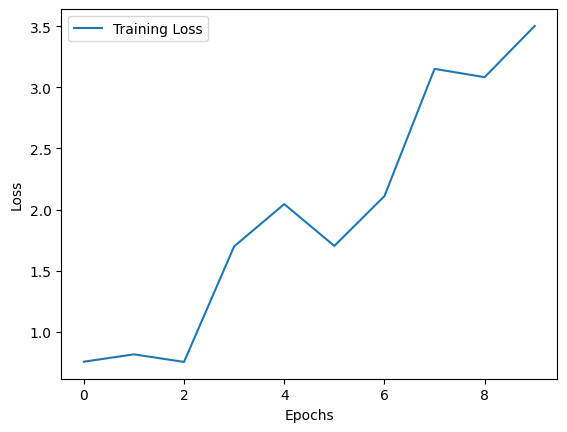

In [26]:
plt.plot(loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# Supongamos que ya has entrenado el modelo y deseas guardarlo
torch.save(combined_model.state_dict(), 'modelo_entrenadoC6.pth')

In [28]:
# Cargar el modelo entrenado
combined_model = CombinedModel(vgg_output_size, gru_hidden_size, gru_num_layers, num_classes)
combined_model.load_state_dict(torch.load('modelo_entrenadoC6.pth'))

c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Main\UVG\Semestre_VIII\Data_science\Proyecto2\envi\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>